In [1]:
!pip install bertopic
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from io import StringIO
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from bertopic import BERTopic

2025-07-11 10:52:56.280090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752231176.472501      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752231176.531539      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/sarcasticdata/webis_sarc_full_comments.csv")
df.head()

,author,body,normalizedBody,subreddit,subreddit_id,id,content,summary,__index_level_0__,input_ids,attention_mask,sarcasm_prediction
0,Z3tta,I've been in the information security field fo...,I've been in the information security field fo...,explainlikeimfive,t5_2sokd,c7pggkf,I've been in the information security field fo...,"Hacking is breaking communication, lying to co...",582,[ 0 100 348 57 11 5 335 5...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,1
1,GiantAxon,The Ontario medical association put an email o...,The Ontario medical association put an email o...,worldnews,t5_2qh13,c8egopy,The Ontario medical association put an email o...,"we might be fucked, also, when it goes down, w...",844,[ 0 133 4170 1131 5259 342 41 10...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,1
2,schmedes2,Just want to add my two cents about acne. The...,Just want to add my two cents about acne. The...,explainlikeimfive,t5_2sokd,c94pvdc,Just want to add my two cents about acne. The...,is acne is an internal problem first and foremost,1156,[ 0 6785 236 7 1606 127 80 32...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,1
3,Eurem,"Yeah, it's fairly obvious that the US governme...","Yeah, it's fairly obvious that the US governme...",worldnews,t5_2qh13,ca70axj,"Yeah, it's fairly obvious that the US governme...","The War on Drugs has always been about racism,...",1545,[ 0 14783 6 24 18 5342 4678 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,1
4,gnarcissus,"Well I'm just going to ignore the ""killing ani...","Well I'm just going to ignore the ""killing ani...",WTF,t5_2qh61,caho6a9,"Well I'm just going to ignore the ""killing ani...",of it is a vegan diet has the lowest environme...,1687,[ 0 8346 38 437 95 164 7 88...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,1


In [4]:
df['comment'] = df['content']
df = df[['comment']].copy()

In [5]:
df

,comment
0,I've been in the information security field fo...
1,The Ontario medical association put an email o...
2,Just want to add my two cents about acne. The...
3,"Yeah, it's fairly obvious that the US governme..."
4,"Well I'm just going to ignore the ""killing ani..."
...,...
4778,I only have an average understanding of techno...
4779,What happened during their trial and why was i...
4780,I understand that when you shower and wash you...
4781,I realize that our eyesight can be permanently...


In [6]:
if "comment" in df.columns:
    comments = df["comment"].astype(str).tolist()
    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(comments)
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    for i in range(5):
        similar_indices = similarity_matrix[i].argsort()[::-1][1:6]
        print(f"\nComment {i+1}: {comments[i][:100]}...")
        print("Most similar comments:")
        for idx in similar_indices:
            print(f"- {comments[idx][:100]}...")
else:
    print("The DataFrame does not contain a 'comment' column.")



Comment 1: I've been in the information security field for the past 6 years. Hackers are just 21st century con ...
Most similar comments:
- We aren't talking about nuclear weapons and nuclear power plants, we're talking about an unaccountab...
- A link to the wikipedia page, and the...
- My one paragraph post is too long for you to read, but you want every law to be long enough so that ...
- Excellent posts kleinbl00! You're posts should be an integral part of the school system! Mandatory k...
- Thanks.  Having recently joined the ranks of useless degree holders myself, it seems like commenting...

Comment 2: The Ontario medical association put an email out about this a long time ago. They were worried that ...
Most similar comments:
- I like how your...
- I like you. The...
- I like your...
- Like how your...
- I like how your...

Comment 3: Just want to add my two cents about acne.  The best way to get rid of it is doing something like the...
Most similar comments:
- When you eat,  

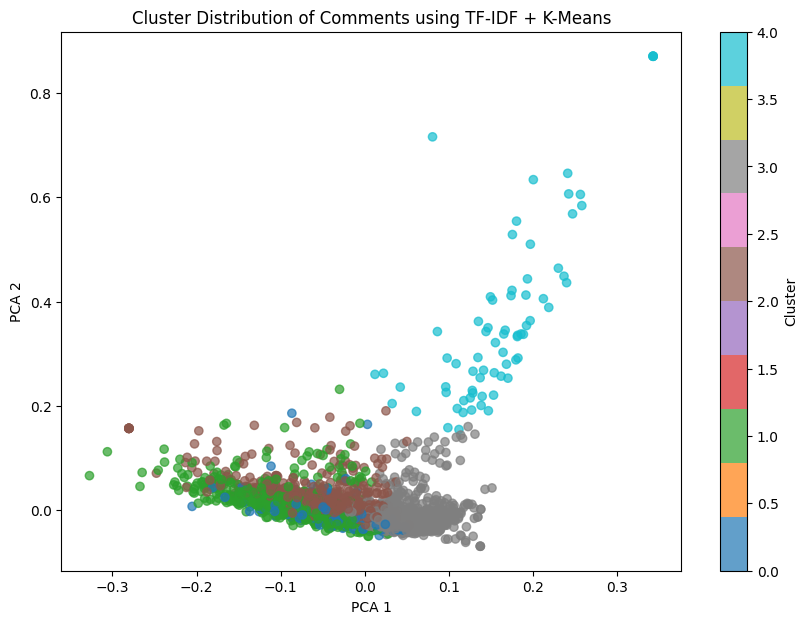

In [7]:
if "comment" in df.columns:
    comments = df["comment"].astype(str).tolist()
    vectorizer = TfidfVectorizer(stop_words="english")
    tfidf_matrix = vectorizer.fit_transform(comments)
    
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(tfidf_matrix.toarray())
    
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='tab10', alpha=0.7)
    plt.title("Cluster Distribution of Comments using TF-IDF + K-Means")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(scatter, label="Cluster")
    plt.show()
else:
    print("The DataFrame does not contain a 'comment' column.")


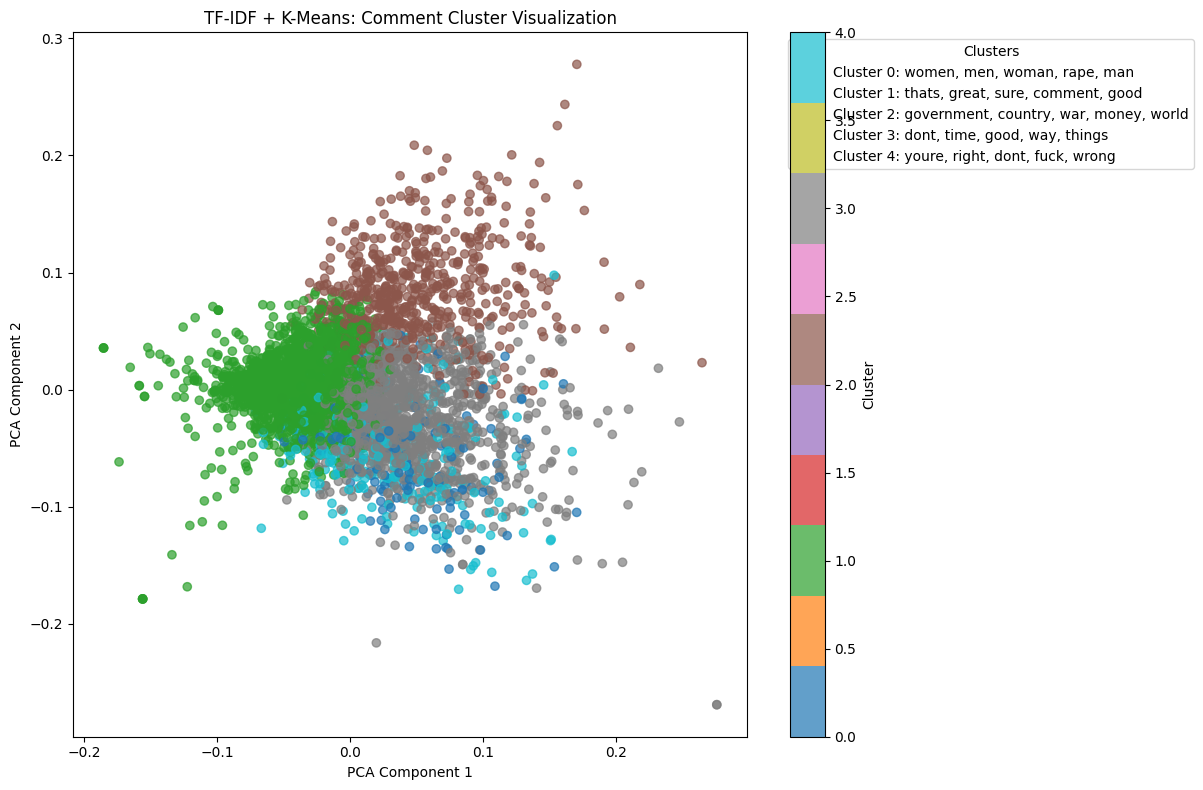

In [8]:
if "comment" in df.columns:
    # Extended stopword list
    custom_stopwords = text.ENGLISH_STOP_WORDS.union({
        'don', 'didn', 'doesn', 'just', 'like', 'people', 'get', 'know', 'think',
        'thing', 'make', 'need', 'read', 'actually', 'post', 'want', 'got',
        'really', 'going', 'one', 'even', 'also', 'say', 'us', 'use'
    })

    # Text preprocessing function
    def preprocess(text):
        text = text.lower()
        text = re.sub(r"[^\w\s]", "", text)          # Remove punctuation
        text = re.sub(r"\b\w{1,2}\b", "", text)       # Remove very short words
        text = re.sub(r"\s+", " ", text).strip()      # Remove extra whitespace
        return text

    # Preprocess comments
    comments = df["comment"].astype(str).apply(preprocess).tolist()

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(stop_words=list(custom_stopwords))
    tfidf_matrix = vectorizer.fit_transform(comments)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # K-Means Clustering
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)
    df["cluster"] = clusters

    # Top 5 words per cluster
    top_terms = {}
    for i in range(n_clusters):
        cluster_center = kmeans.cluster_centers_[i]
        top_indices = cluster_center.argsort()[::-1][:5]
        top_words = [feature_names[idx] for idx in top_indices]
        top_terms[i] = ", ".join(top_words)

    # PCA for 2D visualization
    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(tfidf_matrix.toarray())

    # Plotting
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='tab10', alpha=0.7)

    # Legend with top terms
    handles, _ = scatter.legend_elements()
    labels = [f"Cluster {i}: {top_terms[i]}" for i in range(n_clusters)]
    plt.legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title("TF-IDF + K-Means: Comment Cluster Visualization")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(scatter, label="Cluster")
    plt.tight_layout()
    plt.show()

else:
    print("The DataFrame does not contain a 'comment' column.")


In [9]:
# Topic modeling and visualization on comments using BERTopic
if "comment" in df.columns:
    comments = df["comment"].astype(str).tolist()
    
    # Function to remove stop words
    def remove_stop_words(text):
        # Convert text to lowercase and tokenize
        words = re.findall(r'\b\w+\b', text.lower())
        # Filter out stop words
        filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS]
        return ' '.join(filtered_words)
    
    # Remove stop words from all comments
    cleaned_comments = [remove_stop_words(comment) for comment in comments]
    
    # Create and train the BERTopic model
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(cleaned_comments)
    
    # Visualize topic distribution with a scatter plot
    topic_model.visualize_documents(cleaned_comments)
else:
    print("The 'comment' column was not found in the DataFrame.")


2025-07-11 10:53:40,307 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/150 [00:00<?, ?it/s]

2025-07-11 10:53:50,369 - BERTopic - Embedding - Completed ✓
2025-07-11 10:53:50,369 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-11 10:54:16,226 - BERTopic - Dimensionality - Completed ✓
2025-07-11 10:54:16,227 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-11 10:54:17,209 - BERTopic - Cluster - Completed ✓
2025-07-11 10:54:17,217 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-11 10:54:17,544 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/150 [00:00<?, ?it/s]

In [10]:
topic_info = topic_model.get_topic_info()
print(topic_info.head(5))

   Topic  Count                             Name  \
0     -1   2076          -1_people_just_like_don   
1      0    293     0_religion_islam_god_muslims   
2      1    169             1_women_rape_men_sex   
3      2    134  2_israel_jews_palestinian_hamas   
4      3    123   3_money_economy_currency_banks   

                                      Representation  \
0  [people, just, like, don, know, time, world, t...   
1  [religion, islam, god, muslims, muslim, people...   
2  [women, rape, men, sex, woman, gender, girl, l...   
3  [israel, jews, palestinian, hamas, israeli, pa...   
4  [money, economy, currency, banks, tax, governm...   

                                 Representative_Docs  
0  [ok m saying obviously completely head m dropp...  
1  [mistake shall compare christians muslims geor...  
2  [believe women possess sexual agency weak fore...  
3  [m unimpressed post d recommend book 5 used ba...  
4  [fact need government don t government actuall...  


In [11]:
# Topic 0's keywords
print(topic_model.get_topic(0))

[('religion', 0.025285205511437255), ('islam', 0.025112303910056477), ('god', 0.022199186483315547), ('muslims', 0.02096487813927519), ('muslim', 0.02065084997307889), ('people', 0.012861299218449838), ('religious', 0.012649268934953694), ('christian', 0.012436640472581643), ('church', 0.012334914367380306), ('christians', 0.011579373951851681)]


In [12]:
topic_model.visualize_term_rank(width=500, height=450)


In [13]:
fig = topic_model.visualize_term_rank(width=1800, height=550)
fig.write_html("term_rank.html")

In [14]:
topic_model.visualize_heatmap(width=900, height=900)


In [15]:
fig = topic_model.visualize_heatmap(width=900, height=900)
fig.write_html("visualize_heatmap.html")

In [16]:
topic_model.visualize_barchart(top_n_topics=15, width=800, height=450) 


In [17]:
fig = topic_model.visualize_barchart(top_n_topics=15, width=450, height=500) 
fig.write_html("visualize_barchart.html")

In [18]:
topic_model.visualize_topics(width=900, height=600)  # Clustering in 2D


In [19]:
fig = topic_model.visualize_topics(width=900, height=525)
fig.write_html("visualize_topics.html")

In [20]:
topic_model.visualize_hierarchy(width=900, height=1500)


In [21]:
fig = topic_model.visualize_hierarchy(width=900, height=600)
fig.write_html("visualize_hierarchy.html")

In [22]:
# Get the first 10 topic IDs (excluding -1 which is often the "outlier" or "no-topic")
docs = cleaned_comments
selected_topics = [topic for topic in set(topics) if topic != -1][:15]

# Visualize only those topics
topic_model.visualize_documents(docs, topics=selected_topics, width=1800, height=500)


Batches:   0%|          | 0/150 [00:00<?, ?it/s]

In [27]:

fig = topic_model.visualize_documents(docs, topics=selected_topics, width=1800, height=600)
fig.write_html("visualize_documents.html")

Batches:   0%|          | 0/150 [00:00<?, ?it/s]